<a href="https://colab.research.google.com/github/Gab2697/Human-Activity-Recognition/blob/master/Test_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from scipy import signal
import torch

from keras import layers 
from keras import models
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def open_pickle(path_pickle):
  f = open(path_pickle, 'rb')
  T = pickle.load(f)
  f.close()

  return T

In [4]:
#T13,T14,T15,T16,T17,T18,T19,T21,T22,T23,T25,T26,T27,T28
TTT=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/TTT.pickle')
#T3,T4,T5,T7,T8,T9,T10,T11,T12,T20,T24
T=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/TT.pickle')

#bring all into one
TT = tf.concat([T,TTT], axis=1)

TT.shape

TensorShape([7704, 3959, 6])

In [5]:
#========Initial cutting========
#X-data with shape ((1926frames x 4sec)x(80trials x 2surfaces x n-participants) x 4channels)
X=TT[:, :, 1:5].numpy() #size: (7704, 320, 4)
#Y-categorical encoded label = 1 for asphalt and 0 for grass 
y=TT[:,:,4].numpy() 
#number trials
num_trials= TT.shape[1]

#========Sreshaping into the specific intut format========S 
#keras CNN is looking for X= (batch_size, height, width,depth)
X_reshape = X.reshape((num_trials,7704, 4, 1))
y=y.reshape((num_trials,7704,1))
print("Data shape:", X_reshape.shape) 
print("Label shape:", y.shape)

#========Splitting the data into training and testing sets========S
#data set for training and testing the model
train_size= int(0.8*num_trials) 
X_train= X_reshape[0:train_size,:,:,:]
X_test=X_reshape[train_size:num_trials,:,:,:]
#labels for train and test
y_train=y[0:train_size,:,:] 
y_test=y[train_size:num_trials,:,:]

# ========convert class vectors to binary class matrices========
label_train = to_categorical(y_train, 2)
label_test = to_categorical(y_test, 2)

#========only keeping one label for each trials========
#(instead of a complete vector of the same number)
label_train= label_train[:,0,:]
label_test=label_test[:,0,:]

print("Data shape train:",X_train.shape,"Data shape test:",X_test.shape,"Label shape train:",label_train.shape,"Label shape test:",label_test.shape)

Data shape: (3959, 7704, 4, 1)
Label shape: (3959, 7704, 1)
Data shape train: (3167, 7704, 4, 1) Data shape test: (792, 7704, 4, 1) Label shape train: (3167, 2) Label shape test: (792, 2)


#Baseline CNN

In [14]:
#Instantiating a small convnet
model = models.Sequential()
#filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(7704,4,1),padding='same')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.summary()

#Adding a classifier on top of the convnet
model.add(layers.Flatten()) 
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options
model.summary()

# testing CNN model
num_trial_batch=50
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history= model.fit(X_train, label_train, epochs=5, batch_size=num_trial_batch,validation_split=0.1)   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7704, 4, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3852, 2, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3852, 2, 64)       18496     
                                                                 
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7704, 4, 32)       320       
                                

#Testing Baseline

Add layers

In [ ]:
#Instantiating a small convnet
model = models.Sequential()
#filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(7704,4,1),padding='same')) 
model.add(layers.MaxPooling2D((2, 2)))

#Add layer-------
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same')) 
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.summary()

#Adding a classifier on top of the convnet
model.add(layers.Flatten()) 
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options
model.summary()

# testing CNN model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history= model.fit(X_train, label_train, epochs=5, batch_size=num_trials,validation_split=0.1)   

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 7704, 4, 32)       320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3852, 2, 32)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 3852, 2, 64)       18496     
                                                                 
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 7704, 4, 32)       320       
                            

Bigger layers (more filters)

In [ ]:
#Note: Tried with 512-->crashed RAM,Tried with 128-->crashed RAM, maybe if smaller number of filter, RAM won't crash with all partipicants 
###try 100!!-Phil D with 16x16
#Instantiating a small convnet
model = models.Sequential()
#filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
model.add(layers.Conv2D(52, (3, 3), activation='relu', input_shape=(7704,4,1),padding='same')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(52, (3, 3), activation='relu',padding='same')) 
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.summary()


#Adding a classifier on top of the convnet
model.add(layers.Flatten()) 
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options
model.summary()

# testing CNN model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history= model.fit(X_train, label_train, epochs=5, batch_size=num_trials,validation_split=0.1)   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7704, 4, 52)       520       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3852, 2, 52)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3852, 2, 52)       24388     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1926, 1, 52)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1926, 1, 64)       30016     
                                                                 
Total params: 54,924
Trainable params: 54,924
Non-traina

Less filters= underfit


In [6]:
num_trial_batch=50 
#Instantiating a small convnet
model = models.Sequential()
#filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(7704,4,1),padding='same')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu',padding='same')) 
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
model.summary()


#Adding a classifier on top of the convnet
model.add(layers.Flatten()) 
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options
model.summary()

# testing CNN model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history= model.fit(X_train, label_train, epochs=5, batch_size=num_trial_batch,validation_split=0.1)   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7704, 4, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3852, 2, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3852, 2, 16)       2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1926, 1, 16)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1926, 1, 32)       4640      
                                                                 
Total params: 7,120
Trainable params: 7,120
Non-trainabl

More epochs

In [ ]:
#Instantiating a small convnet
model = models.Sequential()
#filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(7704,4,1),padding='same')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same')) 
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.summary()


#Adding a classifier on top of the convnet
model.add(layers.Flatten()) 
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options
model.summary()

# testing CNN model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history= model.fit(X_train, label_train, epochs=15, batch_size=num_trials,validation_split=0.1)   

#Regularization

Dropout

In [7]:
#Instantiating a small convnet
model = models.Sequential()
#filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(7704,4,1),padding='same')) 
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(layers.Dropout(0.5)) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(layers.Dropout(0.5))
model.summary()


#Adding a classifier on top of the convnet
model.add(layers.Flatten()) 
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options
model.summary()

# testing CNN model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history= model.fit(X_train, label_train, epochs=5, batch_size=50,validation_split=0.1)   

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 7704, 4, 32)       320       
                                                                 
 dropout (Dropout)           (None, 7704, 4, 32)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3852, 2, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 3852, 2, 32)       9248      
                                                                 
 dropout_1 (Dropout)         (None, 3852, 2, 32)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1926, 1, 32)      0         
 2D)                                                  

#HERE!!


Weight regularization-L2 (keeping also dropout)

In [12]:
from keras import regularizers

model = models.Sequential()
#filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(7704,4,1),padding='same')) 
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001),activation='relu',padding='same')) 
# model.add(layers.Dropout(0.5))
# model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu',padding='same'))
model.add(layers.Dropout(0.5))
model.summary()


#Adding a classifier on top of the convnet
model.add(layers.Flatten()) 
model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu')) 
model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options
model.summary()

# testing CNN model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history= model.fit(X_train, label_train, epochs=5, batch_size=50,validation_split=0.1)  

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 7704, 4, 32)       320       
                                                                 
 dropout_13 (Dropout)        (None, 7704, 4, 32)       0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 3852, 2, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 3852, 2, 64)       18496     
                                                                 
 dropout_14 (Dropout)        (None, 3852, 2, 64)       0         
                                                                 
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
__________________________________________________

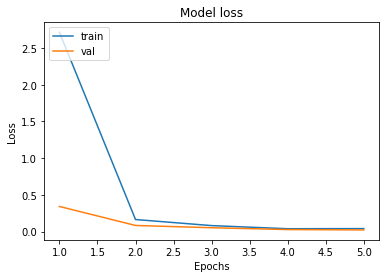

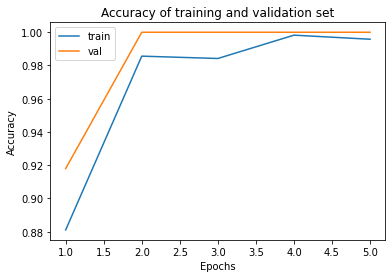

In [13]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Tuning hyper parameters

In [ ]:
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

# Function to create model, required for KerasClassifier
def create_model():
    model = models.Sequential()
    #filter size: 32, kenel of 3x3, input shape without the batch_size (one trial), padding= with zero padding
    model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(7704,4,1),padding='same')) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001),activation='relu',padding='same')) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu',padding='same'))

    #Adding a classifier on top of the convnet
    model.add(layers.Flatten()) 
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu')) 
    model.add(layers.Dense(2, activation='sigmoid')) #last layer has 2 output options

    # testing CNN model
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 

    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [20, 40, 50, 100] 
epochs = [5,10,15,20]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, label_train) #validation_split=0.1
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.982422 using {'batch_size': 40, 'epochs': 15}
0.655934 (0.214509) with: {'batch_size': 10, 'epochs': 5}
0.501938 (0.009049) with: {'batch_size': 10, 'epochs': 10}
0.812831 (0.231591) with: {'batch_size': 10, 'epochs': 15}
0.663731 (0.233670) with: {'batch_size': 10, 'epochs': 20}
0.783500 (0.210814) with: {'batch_size': 20, 'epochs': 5}
0.661782 (0.222773) with: {'batch_size': 20, 'epochs': 10}
0.503887 (0.008398) with: {'batch_size': 20, 'epochs': 15}
0.666632 (0.223299) with: {'batch_size': 20, 'epochs': 20}
0.507809 (0.004965) with: {'batch_size': 40, 'epochs': 5}
0.808898 (0.216369) with: {'batch_size': 40, 'epochs': 10}
0.982422 (0.004775) with: {'batch_size': 40, 'epochs': 15}
0.659833 (0.228158) with: {'batch_size': 40, 'epochs': 20}
0.957023 (0.005580) with: {'batch_size': 60, 'epochs': 5}
0.820628 (0.228786) with: {'batch_size': 60, 'epochs': 10}
0.771850 (0.198468) with: {'batch_size': 60, 'epochs': 15}
0.645121 (0.213622) with: {'batch_size': 60, 'epochs': 20}
0.6019

In [ ]:


## define the grid search parameters
  # number of units per layer: filter?
numb_filter= [16,32,64]
  # the learning rate of the optimizer
#'lr' : [0.001,0.01,0.1] 
  # window length
window = [1926, 3852, 5778, 7704]
  #number of epochs

  #filter size

Different combination of channels

In [ ]:
#--------#COMBINATION OF 4#--------#
#Option 1: ALL 4
X_train=X_train

#--------#COMBINATION OF 1#--------#
#Option 2: Only TA
X_train=X_train[0]
#Option 3: Only Gastroc
X_train=X_train[1]
#Option 4: Only RF
X_train=X_train[2]
#Option 5: Only BF
X_train=X_train[3]

#--------#COMBINATION OF 2#--------#
#Option 6: TA,Gastroc
X_train=X_train[0:1]
#Option 7: TA,RF
X_train=X_train[0:2:2]
#Option 8: TA,BF
X_train=X_train[0:3:3]
#Option 9: Gastroc,RF
X_train=X_train[1:2]
#Option 10: Gastroc,BF
X_train=X_train[1:3:2]
#Option 11: RF,BF
X_train=X_train[2:3]

#--------#COMBINATION OF 3#--------#
#Option 12: TA,Gastroc, RF
X_train=X_train[0:2]
#Option 13: TA,Gastroc, BF
X_train=X_train[0:1]+X_train[3]####not sure how to do this####-----------------------
#Option 14: TA,RF, BF
X_train=X_train[0]+X_train[2:3]####not sure how to do this####-----------------------
#Option 15: Gastroc, RF,BF
X_train=X_train[1:3]

In [ ]:
X_train

In [ ]:
#========Initial cutting========
#X-data with shape ((1926frames x 4sec)x(80trials x 2surfaces x n-participants) x 4channels)
X=TT[:, :, 1:5].numpy() #size: (7704, 320, 4)
#Y-categorical encoded label = 1 for asphalt and 0 for grass 
y=TT[:,:,4].numpy() 
#number trials
num_trials= TT.shape[1]

#========Sreshaping into the specific intut format========S 
#keras CNN is looking for X= (batch_size, height, width,depth)
X_reshape = X.reshape((num_trials,7704, 4, 1))
y=y.reshape((num_trials,7704,1))
print("Data shape:", X_reshape.shape) 
print("Label shape:", y.shape)

#========Splitting the data into training and testing sets========S
#data set for training and testing the model
train_size= int(0.8*num_trials) 
X_train= X_reshape[0:train_size,:,:,:]
X_test=X_reshape[train_size:num_trials,:,:,:]
#labels for train and test
y_train=y[0:train_size,:,:] 
y_test=y[train_size:num_trials,:,:]

# ========convert class vectors to binary class matrices========
label_train = to_categorical(y_train, 2)
label_test = to_categorical(y_test, 2)

#========only keeping one label for each trials========
#(instead of a complete vector of the same number)
label_train= label_train[:,0,:]
label_test=label_test[:,0,:]

print("Data shape train:",X_train.shape,"Data shape test:",X_test.shape,"Label shape train:",label_train.shape,"Label shape test:",label_test.shape)